<a href="https://colab.research.google.com/github/CeiYsBennova/DACN/blob/main/DDQN_CICIDS2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import backend as K
import json
from sklearn.utils import shuffle
import os
import sys
import time


class data_cls:
    def __init__(self, train_test):
        self.index = 0

        if train_test == 'train':
            self.train_path = '/content/drive/MyDrive/ML/CIC-IDS-2017/ADASYN/train.csv'
        else:
            self.train_path = '/content/drive/MyDrive/ML/CIC-IDS-2017/ADASYN/test.csv'

        self.df = pd.read_csv(self.train_path)

        #self.df = pd.get_dummies(self.df, columns=[self.df.columns[-1]])

        self.attack_types = ['label_0', 'label_1']#, 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9']
        self.all_attack_types = ['label_0', 'label_1']#, 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9']
        self.attack_names = ['label_0', 'label_1']#, 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9']

        self.attack_map = {'label_0':'label_0', 'label_1':'label_1'}#, 'label_2':'label_2', 'label_3':'label_3', 'label_4':'label_4', 'label_5':'label_5', 'label_6':'label_6', 'label_7':'label_7', 'label_8':'label_8', 'label_9':'label_9' }
        self.all_attack_names = list(self.attack_map.keys())

        self.df = self.df.sample(frac=1).reset_index(drop=True)

    def get_shape(self):
        return self.df.shape

    def get_batch(self, batch_size=100):
        indexes = list(range(self.index, self.index+batch_size))
        if max(indexes) > self.df.shape[0]-1:
            dif = max(indexes) - (self.df.shape[0])
            indexes[len(indexes)-dif-1:len(indexes)] = list(range(dif + 1))
            self.index = batch_size - dif
            batch = self.df.iloc[indexes]
        else:
            batch = self.df.iloc[indexes]
            self.index += batch_size

        labels = batch[self.attack_names]
        batch = batch.drop(self.all_attack_names, axis=1)

        return batch, labels

    def get_full(self):
        labels = self.df[self.attack_names]
        batch = self.df.drop(self.all_attack_names, axis=1)

        return batch, labels

In [ ]:
# Huber loss function
def huber_loss(y_true, y_pred, clip_value=1):
    assert clip_value > 0.

    x = y_true - y_pred
    if np.isinf(clip_value):
        return .5 * K.square(x)

    condition = K.abs(x) < clip_value
    squared_loss = .5 * K.square(x)
    linear_loss = clip_value * (K.abs(x) - .5 * clip_value)
    if K.backend() == 'tensorflow':
        import tensorflow as tf
        if hasattr(tf, 'select'):
            return tf.select(condition, squared_loss, linear_loss)
        else:
            return tf.where(condition, squared_loss, linear_loss)

import keras.losses
keras.losses.huber_loss = huber_loss

In [ ]:
class QNetwork():

    def __init__(self,obs_size,num_actions,hidden_size = 100,
                 hidden_layers = 1,learning_rate=.2):
        self.obs_size = obs_size
        self.num_actions = num_actions

        self.model = Sequential()
        self.model.add(Dense(hidden_size, input_shape=(obs_size,),
                             activation='relu'))
        for layers in range(hidden_layers):
            self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(num_actions))

        optimizer = optimizers.Adam(0.00025)
        self.model.compile(loss=huber_loss,optimizer=optimizer)

    def predict(self,state,batch_size=1):
        return self.model.predict(state,batch_size=batch_size)

    def update(self, states, q):
        loss = self.model.train_on_batch(states, q)
        return loss

    def copy_model(model):
        model.save('tmp_model')
        return keras.models.load_model('tmp_model')


In [ ]:

class Policy:
    def __init__(self, num_actions, estimator):
        self.num_actions = num_actions
        self.estimator = estimator

class Epsilon_greedy(Policy):
    def __init__(self,estimator ,num_actions ,epsilon,min_epsilon,decay_rate, epoch_length):
        Policy.__init__(self, num_actions, estimator)
        self.name = "Epsilon Greedy"

        if (epsilon is None or epsilon < 0 or epsilon > 1):
            print("EpsilonGreedy: Invalid value of epsilon", flush = True)
            sys.exit(0)
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.actions = list(range(num_actions))
        self.step_counter = 0
        self.epoch_length = epoch_length
        self.decay_rate = decay_rate

        if self.epsilon > 0.01:
            self.epsilon_decay = True
        else:
            self.epsilon_decay = False

    def get_actions(self,states):
        if np.random.rand() <= self.epsilon:
            actions = np.random.randint(0, self.num_actions,states.shape[0])
        else:
            self.Q = self.estimator.predict(states,states.shape[0])
            actions = []
            for row in range(self.Q.shape[0]):
                best_actions = np.argwhere(self.Q[row] == np.amax(self.Q[row]))
                actions.append(best_actions[np.random.choice(len(best_actions))].item())

        self.step_counter += 1
        if self.epsilon_decay:
            if self.step_counter % self.epoch_length == 0:
                self.epsilon = max(self.min_epsilon, self.epsilon * self.decay_rate**self.step_counter)

        return actions

In [ ]:
class ReplayMemory(object):
    def __init__(self, observation_size, max_size):
        self.observation_size = observation_size
        self.num_observed = 0
        self.max_size = max_size
        self.samples = {
                 'obs'      : np.zeros(self.max_size * 1 * self.observation_size,
                                       dtype=np.float32).reshape(self.max_size,self.observation_size),
                 'action'   : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
                 'reward'   : np.zeros(self.max_size * 1).reshape(self.max_size, 1),
                 'terminal' : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
               }

    def observe(self, state, action, reward, done):
        index = self.num_observed % self.max_size
        self.samples['obs'][index, :] = state
        self.samples['action'][index, :] = action
        self.samples['reward'][index, :] = reward
        self.samples['terminal'][index, :] = done

        self.num_observed += 1

    def sample_minibatch(self, minibatch_size):
        max_index = min(self.num_observed, self.max_size) - 1
        sampled_indices = np.random.randint(max_index, size=minibatch_size)

        s      = np.asarray(self.samples['obs'][sampled_indices, :], dtype=np.float32)
        s_next = np.asarray(self.samples['obs'][sampled_indices+1, :], dtype=np.float32)

        a      = self.samples['action'][sampled_indices].reshape(minibatch_size)
        r      = self.samples['reward'][sampled_indices].reshape((minibatch_size, 1))
        done   = self.samples['terminal'][sampled_indices].reshape((minibatch_size, 1))

        return (s, a, r, s_next, done)

In [ ]:
class Agent(object):

    def __init__(self, actions,obs_size, policy="EpsilonGreedy", **kwargs):
        self.actions = actions
        self.num_actions = len(actions)
        self.obs_size = obs_size

        self.epsilon = kwargs.get('epsilon', 1)
        self.min_epsilon = kwargs.get('min_epsilon', .1)
        self.gamma = kwargs.get('gamma', .001)
        self.minibatch_size = kwargs.get('minibatch_size', 2)
        self.epoch_length = kwargs.get('epoch_length', 100)
        self.decay_rate = kwargs.get('decay_rate',0.99)
        self.ExpRep = kwargs.get('ExpRep',True)
        if self.ExpRep:
            self.memory = ReplayMemory(self.obs_size, kwargs.get('mem_size', 10))

        self.ddqn_time = 100
        self.ddqn_update = self.ddqn_time


        self.model_network = QNetwork(self.obs_size, self.num_actions,
                                      kwargs.get('hidden_size', 100),
                                      kwargs.get('hidden_layers',1),
                                      kwargs.get('learning_rate',.2))
        self.target_model_network = QNetwork(self.obs_size, self.num_actions,
                                      kwargs.get('hidden_size', 100),
                                      kwargs.get('hidden_layers',1),
                                      kwargs.get('learning_rate',.2))
        self.target_model_network.model = QNetwork.copy_model(self.model_network.model)

        if policy == "EpsilonGreedy":
            self.policy = Epsilon_greedy(self.model_network,len(actions),
                                         self.epsilon,self.min_epsilon,
                                         self.decay_rate,self.epoch_length)


    def learn(self, states, actions,next_states, rewards, done):
        if self.ExpRep:
            self.memory.observe(states, actions, rewards, done)
        else:
            self.states = states
            self.actions = actions
            self.next_states = next_states
            self.rewards = rewards
            self.done = done
    def update_model(self):
        if self.ExpRep:
            (states, actions, rewards, next_states, done) = self.memory.sample_minibatch(self.minibatch_size)
        else:
            states = self.states
            rewards = self.rewards
            next_states = self.next_states
            actions = self.actions
            done = self.done

        next_actions = []
        Q_prime = self.target_model_network.predict(next_states,self.minibatch_size)
        for row in range(Q_prime.shape[0]):
            best_next_actions = np.argwhere(Q_prime[row] == np.amax(Q_prime[row]))
            next_actions.append(best_next_actions[np.random.choice(len(best_next_actions))].item())
        sx = np.arange(len(next_actions))
        Q = self.model_network.predict(states,self.minibatch_size)
        targets = rewards.reshape(Q[sx,actions].shape) + \
                  self.gamma * Q[sx,next_actions] * \
                  (1-done.reshape(Q[sx,actions].shape))
        Q[sx,actions] = targets

        loss = self.model_network.model.train_on_batch(states,Q)

        self.ddqn_update -= 1
        if self.ddqn_update == 0:
            self.ddqn_update = self.ddqn_time
            self.target_model_network.model.set_weights(self.model_network.model.get_weights())

        return loss

    def act(self, state,policy):
        raise NotImplementedError

In [ ]:
class DefenderAgent(Agent):
    def __init__(self, actions, obs_size, policy="EpsilonGreedy", **kwargs):
        super().__init__(actions,obs_size, policy="EpsilonGreedy", **kwargs)

    def act(self,states):
        actions = self.policy.get_actions(states)
        return actions

class AttackAgent(Agent):
    def __init__(self, actions, obs_size, policy="EpsilonGreedy", **kwargs):
        super().__init__(actions,obs_size, policy="EpsilonGreedy", **kwargs)

    def act(self,states):
        actions = self.policy.get_actions(states)
        return actions

In [ ]:

class RLenv(data_cls):
    def __init__(self,train_test,**kwargs):
        data_cls.__init__(self,train_test)
        self.data_shape = data_cls.get_shape(self)
        self.batch_size = kwargs.get('batch_size',1)
        self.iterations_episode = kwargs.get('iterations_episode',10)

    def _update_state(self):
        self.states,self.labels = data_cls.get_batch(self)

        self.true_labels += np.sum(self.labels).values

    def reset(self):
        self.def_true_labels = np.zeros(len(self.attack_types),dtype=int)
        self.def_estimated_labels = np.zeros(len(self.attack_types),dtype=int)
        self.att_true_labels = np.zeros(len(self.attack_names),dtype=int)

        self.state_numb = 0

        self.states,self.labels = data_cls.get_batch(self,self.batch_size)

        self.total_reward = 0
        self.steps_in_episode = 0
        return self.states.values

    def act(self,defender_actions,attack_actions):
        self.att_reward = np.zeros(len(attack_actions))
        self.def_reward = np.zeros(len(defender_actions))


        attack = [self.attack_types.index(self.attack_map[self.attack_names[att]]) for att in attack_actions]

        self.def_reward = (np.asarray(defender_actions)==np.asarray(attack))*1
        self.att_reward = (np.asarray(defender_actions)!=np.asarray(attack))*1



        self.def_estimated_labels += np.bincount(defender_actions,minlength=len(self.attack_types))

        for act in attack_actions:
            self.def_true_labels[self.attack_types.index(self.attack_map[self.attack_names[act]])] += 1

        attack_actions = attacker_agent.act(self.states)
        self.states = env.get_states(attack_actions)

        self.done = np.zeros(len(attack_actions),dtype=bool)

        return self.states, self.def_reward,self.att_reward, attack_actions, self.done

    def get_states(self,attacker_actions):
        first = True
        for attack in attacker_actions:
            if first:
                minibatch = (self.df[self.df[self.attack_names[attack]]==1].sample(1))
                first = False
            else:
                minibatch=minibatch.append(self.df[self.df[self.attack_names[attack]]==1].sample(1))

        self.labels = minibatch[self.attack_names]
        minibatch.drop(self.all_attack_names,axis=1,inplace=True)
        self.states = minibatch

        return self.states



In [ ]:
    batch_size = 1
    minibatch_size = 100
    ExpRep = True

    iterations_episode = 100

    env = RLenv("train",batch_size=batch_size,
                iterations_episode=iterations_episode)
    obs_size = env.data_shape[1]-len(env.all_attack_names)

    num_episodes = 100

    defender_valid_actions = list(range(len(env.attack_types)))
    defender_num_actions = len(defender_valid_actions)


    def_epsilon = 1
    min_epsilon = 0.01
    def_gamma = 0.001
    def_decay_rate = 0.99

    def_hidden_size = 100
    def_hidden_layers = 3

    def_learning_rate = .2

    defender_agent = DefenderAgent(defender_valid_actions,obs_size,"EpsilonGreedy",
                          epoch_length = iterations_episode,
                          epsilon = def_epsilon,
                          min_epsilon = min_epsilon,
                          decay_rate = def_decay_rate,
                          gamma = def_gamma,
                          hidden_size=def_hidden_size,
                          hidden_layers=def_hidden_layers,
                          minibatch_size = minibatch_size,
                          mem_size = 1000,
                          learning_rate=def_learning_rate,
                          ExpRep=ExpRep)

    attack_valid_actions = list(range(len(env.attack_names)))
    attack_num_actions = len(attack_valid_actions)

    att_epsilon = 1
    min_epsilon = 0.82

    att_gamma = 0.001
    att_decay_rate = 0.99

    att_hidden_layers = 1
    att_hidden_size = 100

    att_learning_rate = 0.2

    attacker_agent = AttackAgent(attack_valid_actions,obs_size,"EpsilonGreedy",
                          epoch_length = iterations_episode,
                          epsilon = att_epsilon,
                          min_epsilon = min_epsilon,
                          decay_rate = att_decay_rate,
                          gamma = att_gamma,
                          hidden_size=att_hidden_size,
                          hidden_layers=att_hidden_layers,
                          minibatch_size = minibatch_size,
                          mem_size = 1000,
                          learning_rate=att_learning_rate,
                          ExpRep=ExpRep)



    att_reward_chain = []
    def_reward_chain = []
    att_loss_chain = []
    def_loss_chain = []
    def_total_reward_chain = []
    att_total_reward_chain = []

    print("-------------------------------------------------------------------------------")
    print("Total epoch: {} | Iterations in epoch: {}"
          "| Minibatch from mem size: {} | Total Samples: {}|".format(num_episodes,
                         iterations_episode,minibatch_size,
                         num_episodes*iterations_episode))
    print("-------------------------------------------------------------------------------")
    print("Dataset shape: {}".format(env.data_shape))
    print("-------------------------------------------------------------------------------")
    print("Attacker parameters: Num_actions={} | gamma={} |"
          " epsilon={} | ANN hidden size={} | "
          "ANN hidden layers={}|".format(attack_num_actions,
                             att_gamma,att_epsilon, att_hidden_size,
                             att_hidden_layers))
    print("-------------------------------------------------------------------------------")
    print("Defense parameters: Num_actions={} | gamma={} | "
          "epsilon={} | ANN hidden size={} |"
          " ANN hidden layers={}|".format(defender_num_actions,
                              def_gamma,def_epsilon,def_hidden_size,
                              def_hidden_layers))
    print("-------------------------------------------------------------------------------")

    attacks_by_epoch = []
    attack_labels_list = []
    for epoch in range(num_episodes):
        start_time = time.time()
        att_loss = 0.
        def_loss = 0.
        def_total_reward_by_episode = 0
        att_total_reward_by_episode = 0

        states = env.reset()

        attack_actions = attacker_agent.act(states)
        states = env.get_states(attack_actions)

        done = False

        attacks_list = []
        for i_iteration in range(iterations_episode):

            attacks_list.append(attack_actions[0])

            act_time = time.time()
            defender_actions = defender_agent.act(states)

            next_states,def_reward, att_reward,next_attack_actions, done = env.act(defender_actions,attack_actions)


            attacker_agent.learn(states,attack_actions,next_states,att_reward,done)
            defender_agent.learn(states,defender_actions,next_states,def_reward,done)

            act_end_time = time.time()

            if ExpRep and epoch*iterations_episode + i_iteration >= minibatch_size:
                def_loss += defender_agent.update_model()
                att_loss += attacker_agent.update_model()
            elif not ExpRep:
                def_loss += defender_agent.update_model()
                att_loss += attacker_agent.update_model()


            update_end_time = time.time()

            states = next_states
            attack_actions = next_attack_actions

            def_total_reward_by_episode += np.sum(def_reward,dtype=np.int32)
            att_total_reward_by_episode += np.sum(att_reward,dtype=np.int32)

        attacks_by_epoch.append(attacks_list)
        def_reward_chain.append(def_total_reward_by_episode)
        att_reward_chain.append(att_total_reward_by_episode)
        def_loss_chain.append(def_loss)
        att_loss_chain.append(att_loss)


        end_time = time.time()
        print("\r\n|Epoch {:03d}/{:03d}| time: {:2.2f}|\r\n"
                "|Def Loss {:4.4f} | Def Reward in ep {:03d}|\r\n"
                "|Att Loss {:4.4f} | Att Reward in ep {:03d}|"
                .format(epoch, num_episodes,(end_time-start_time),
                def_loss, def_total_reward_by_episode,
                att_loss, att_total_reward_by_episode))


        print("|Def Estimated: {}| Att Labels: {}".format(env.def_estimated_labels,
              env.def_true_labels))
        attack_labels_list.append(env.def_true_labels)

-------------------------------------------------------------------------------
Total epoch: 100 | Iterations in epoch: 100| Minibatch from mem size: 100 | Total Samples: 10000|
-------------------------------------------------------------------------------
Dataset shape: (1221116, 25)
-------------------------------------------------------------------------------
Attacker parameters: Num_actions=2 | gamma=0.001 | epsilon=1 | ANN hidden size=100 | ANN hidden layers=1|
-------------------------------------------------------------------------------
Defense parameters: Num_actions=2 | gamma=0.001 | epsilon=1 | ANN hidden size=100 | ANN hidden layers=3|
-------------------------------------------------------------------------------

|Epoch 000/100| time: 8.29|
|Def Loss 0.0000 | Def Reward in ep 051|
|Att Loss 0.0000 | Att Reward in ep 049|
|Def Estimated: [47 53]| Att Labels: [54 46]
1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 91ms/step


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 28ms/step

|Epoch 090/100| time: 75.45|
|Def Loss 1.0025 | Def Reward in ep 095|
|Att Loss 0.8472 | Att Reward in ep 005|
|Def Estimated: [58 42]| Att Labels: [57 43]
1/1 [==============================] - 0s 25ms/step

|Epoch 091/100| time: 73.45|
|Def Loss 0.9088 | Def Reward in ep 093|
|Att Loss 0.8035 | Att Reward in ep 007|
|Def Estimated: [50 50]| Att Labels: [49 51]
1/1 [==============================] - 0s 27ms/step

|Epoch 092/100| time: 73.25|
|Def Loss 0.8876 | Def Reward in ep 090|
|Att Loss 0.8634 | Att Reward in ep 010|
|Def Estimated: [46 54]| Att Labels: [50 50]
1/1 [==============================] - 0s 24ms/step

|Epoch 093/100| time: 71.92|
|Def Loss 0.8866 | Def Reward in ep 088|
|Att Loss 0.8714 | Att Reward in ep 012|
|Def Estimated: [52 48]| Att Labels: [52 48]
1/1 [==============================] - 0s 27ms/step

|Epoch 094/100| time: 73.77|
|Def Loss 0.9307 | Def Re

In [ ]:
    # Save the model
    defender_agent.model_network.model.save_weights("/content/drive/MyDrive/ML/CIC-IDS-2017/ADASYN_Model/def_model.h5")
    with open('/content/drive/MyDrive/ML/CIC-IDS-2017/ADASYN_Model/def_model.json', 'w') as fp:
        json.dump(defender_agent.model_network.model.to_json(), fp)

    # Save the model
    attacker_agent.model_network.model.save_weights("/content/drive/MyDrive/ML/CIC-IDS-2017/ADASYN_Model/att_model.h5")
    with open('/content/drive/MyDrive/ML/CIC-IDS-2017/ADASYN_Model/att_model.json', 'w') as fp:
        json.dump(attacker_agent.model_network.model.to_json(), fp)

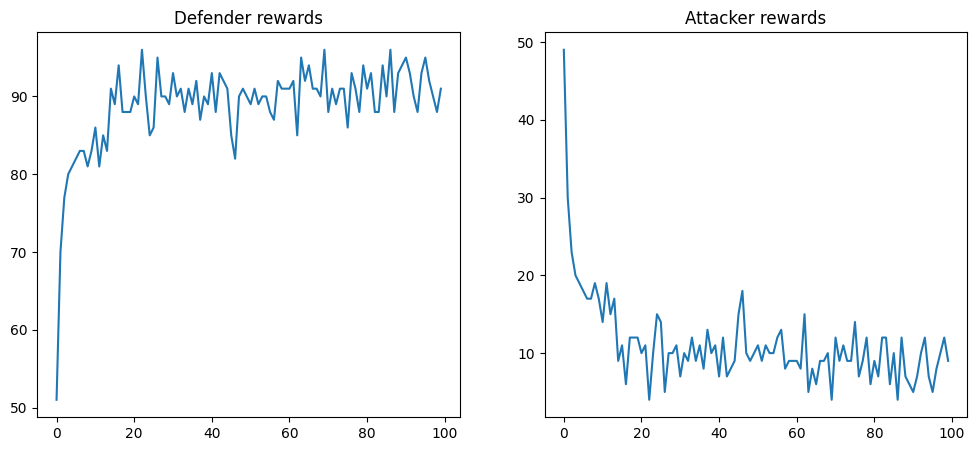

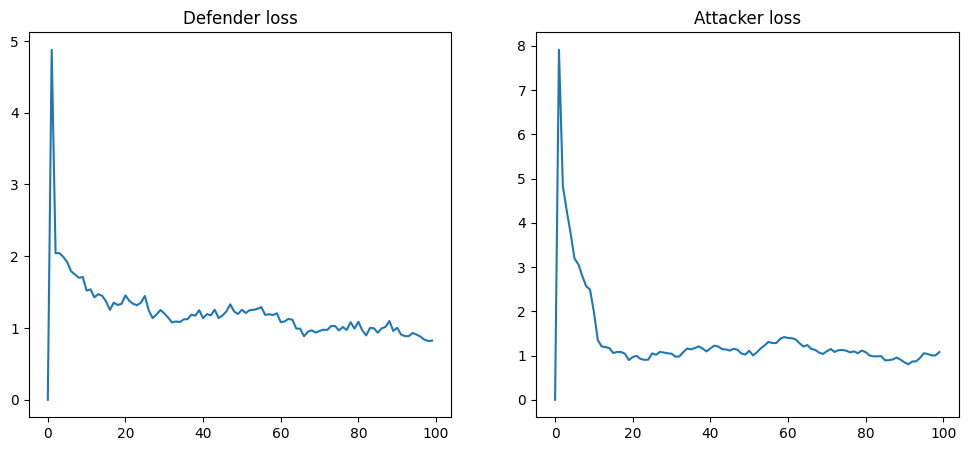

In [ ]:
    # plot training results
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(def_reward_chain)
    plt.title("Defender rewards")
    plt.subplot(122)
    plt.plot(att_reward_chain)
    plt.title("Attacker rewards")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(def_loss_chain)
    plt.title("Defender loss")

    plt.subplot(122)
    plt.plot(att_loss_chain)
    plt.title("Attacker loss")
    plt.show()

In [ ]:
    from keras.models import model_from_json

    import itertools
    from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

    def plot_confusion_matrix(confusion_matrix, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        if normalize:
            confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(confusion_matrix)

        plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks)
        plt.yticks(tick_marks)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [ ]:
    # open def model
    with open('/content/drive/MyDrive/ML/CIC-IDS-2017/ADASYN_Model/def_model.json', 'r') as fp:
        def_model = model_from_json(json.load(fp))
    # load weights into new model
    def_model.load_weights("/content/drive/MyDrive/ML/CIC-IDS-2017/ADASYN_Model/def_model.h5")

    #compile model with huber loss and sgd optimizer
    def_model.compile(loss=huber_loss,optimizer="sgd")

    # define environment
    env_test = RLenv("test",batch_size=batch_size,
                    iterations_episode=iterations_episode)

    total_reward = 0

    true_labels = np.zeros(len(env_test.attack_types),dtype=int)
    estimated_labels = np.zeros(len(env_test.attack_types),dtype=int)
    estimated_correct_labels = np.zeros(len(env_test.attack_types),dtype=int)

    states , labels = env_test.get_full()

    start_time=time.time()
    q = def_model.predict(states)
    actions = np.argmax(q,axis=1)

11925/11925 [==============================] - 20s 2ms/step


In [ ]:
    maped =[]
    for indx, label in labels.iterrows():
        maped.append(env_test.attack_types.index(env_test.attack_map[label.idxmax()]))

    labels, counts = np.unique(maped, return_counts=True)
    true_labels[labels] += counts

    for indx, action in enumerate(actions):
        estimated_labels[action] += 1
        if action == maped[indx]:
            estimated_correct_labels[action] += 1
            total_reward += 1

    action_dummies = pd.get_dummies(actions)
    posible_actions= np.arange(len(env_test.attack_types))
    for non_existing_action in posible_actions:
        if non_existing_action not in action_dummies.columns:
            action_dummies[non_existing_action] = np.uint8(0)

    labels_dummies = pd.get_dummies(maped)

    label_0_f1_score = f1_score(labels_dummies[0].values, action_dummies[0].values)
    label_1_f1_score = f1_score(labels_dummies[1].values, action_dummies[1].values)
    '''
    label_2_f1_score = f1_score(labels_dummies[2].values, action_dummies[2].values)
    label_3_f1_score = f1_score(labels_dummies[3].values, action_dummies[3].values)
    label_4_f1_score = f1_score(labels_dummies[4].values, action_dummies[4].values)
    label_5_f1_score = f1_score(labels_dummies[5].values, action_dummies[5].values)
    label_6_f1_score = f1_score(labels_dummies[6].values, action_dummies[6].values)
    label_7_f1_score = f1_score(labels_dummies[7].values, action_dummies[7].values)
    label_8_f1_score = f1_score(labels_dummies[8].values, action_dummies[8].values)
    label_9_f1_score = f1_score(labels_dummies[9].values, action_dummies[9].values)
    '''
    accuracy_score = [label_0_f1_score, label_1_f1_score]#, label_2_f1_score, label_3_f1_score, label_4_f1_score, label_5_f1_score, label_6_f1_score, label_7_f1_score, label_8_f1_score, label_9_f1_score]
    mismatch = estimated_labels - true_labels

    acc = float(100*total_reward/len(states))
    print ("\r\nTotal reward: {} | Accuracy: {}% | Time: {:2.2f} |".format(total_reward,acc,(time.time()-start_time)))




Total reward: 357573 | Accuracy: 93.70386190739494% | Time: 82.83 |


In [ ]:
    final_rp = np.array(maped)

    print("Results for the test set:")
    #print('Accuracy: {:.4f}'.format(accuracy_score(final_rp, actions)))
    print('F1 score: {:.4f}'.format(f1_score(final_rp, actions, average='weighted')))
    print('Recall: {:.4f}'.format(recall_score(final_rp, actions, average='weighted')))
    print('Precision: {:.4f}'.format(precision_score(final_rp, actions, average='weighted')))

Results for the test set:
F1 score: 0.9422
Recall: 0.9370
Precision: 0.9541


Confusion matrix, without normalization
[[ 35110   3063]
 [ 20963 322463]]


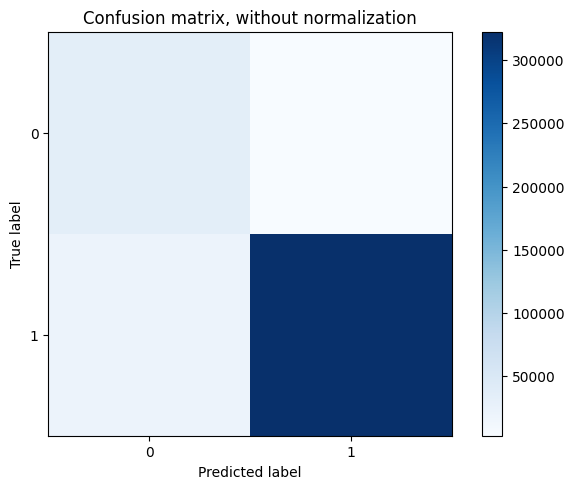

In [ ]:
    cnf_matrix = confusion_matrix(final_rp, actions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=env_test.attack_types,
                              title='Confusion matrix, without normalization')

    plt.show()

In [ ]:
    # print classification report
    from sklearn.metrics import classification_report
    print(classification_report(final_rp, actions, target_names=env_test.attack_types))

              precision    recall  f1-score   support

     label_0       0.63      0.92      0.75     38173
     label_1       0.99      0.94      0.96    343426

    accuracy                           0.94    381599
   macro avg       0.81      0.93      0.85    381599
weighted avg       0.95      0.94      0.94    381599

